In [1]:
import platform
import os

from Detector_Classes.M3RefTracking import M3RefTracking
from Detector_Classes.DetectorConfigLoader import DetectorConfigLoader
from Detector_Classes.DreamDetector import DreamDetector

from det_classes_test import plot_ray_hits_2d, align_dream, get_residuals, get_efficiency

In [2]:
# Check if platform is Windows or Linux
if platform.system() == 'Windows':
    base_dir = 'F:/Saclay/cosmic_data/'
    det_type_info_dir = 'C:/Users/Dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = 'F:/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 100  # Number of files to process at once
elif platform.system() == 'Linux':
    base_dir = '/local/home/dn277127/Bureau/cosmic_data/'
    det_type_info_dir = '/local/home/dn277127/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/local/home/dn277127/Bureau/cosmic_data/Analysis/11-15-24/'
    chunk_size = 7  # Number of files to process at once
else:
    raise OSError('Unknown platform')

run_name = 'ip1_test_2-26-25'
run_dir = f'{base_dir}{run_name}/'
sub_run_name = 'long_run_1'

det_single = 'inter_plein_1'

# file_nums = list(range(10, 20))
file_nums = 'all'

noise_threshold_sigmas = 3

realign_dream = False  # If False, read alignment from file, if True, realign Dream detector

run_json_path = f'{run_dir}run_config.json'
data_dir = f'{run_dir}{sub_run_name}/filtered_root/'
ped_dir = f'{run_dir}{sub_run_name}/decoded_root/'
m3_dir = f'{run_dir}{sub_run_name}/m3_tracking_root/'
alignment_dir = f'{run_dir}alignments/'

z_align_range = [5, 5]  # mm range to search for optimal z position
z_rot_range = [-5, 5]

try:
    os.mkdir(alignment_dir)
except FileExistsError:
    pass
try:
    os.mkdir(out_dir)
except FileExistsError:
    pass

In [3]:
print(f'Getting ray data...')
ray_data = M3RefTracking(m3_dir, single_track=True, file_nums=file_nums)

Getting ray data...


100%|██████████| 17/17 [00:00<00:00, 37.00it/s]


In [4]:
det_config_loader = DetectorConfigLoader(run_json_path, det_type_info_dir)

In [5]:
det_config = det_config_loader.get_det_config(det_single, sub_run_name=sub_run_name)
det = DreamDetector(config=det_config)
det.center[2] = 712
print(f'FEU Num: {det.feu_num}')
print(f'FEU Channels: {det.feu_connectors}')
print(f'HV: {det.hv}')

print(f'Detector center: {det.center}')
print(f'Detector active size: {det.active_size}')

# det.load_dream_data(data_dir, ped_dir, noise_threshold_sigmas, file_nums, chunk_size, hist_raw_amps=True, save_waveforms=True)
det.load_dream_data(data_dir, ped_dir, noise_threshold_sigmas, file_nums, chunk_size, hist_raw_amps=True, save_waveforms=False)
print(f'Hits shape: {det.dream_data.hits.shape}')

FEU Num: 6
FEU Channels: [1, 2, 3, 4]
HV: {'drift': 800, 'resist_2': 450}
Detector center: [  9.2  38.4 712. ]
Detector active size: [127.125 127.      4.   ]
Reading in data...


100%|██████████| 17/17 [00:07<00:00,  2.18it/s]


Read in data shape: (24656, 256, 32)
Getting amplitudes...


100%|██████████| 15/15 [00:00<00:00, 46.81it/s]

Fitting time: 0.3910677433013916 s
Processed chunk 1/1
Getting hits...
Hits shape: (24656, 256)


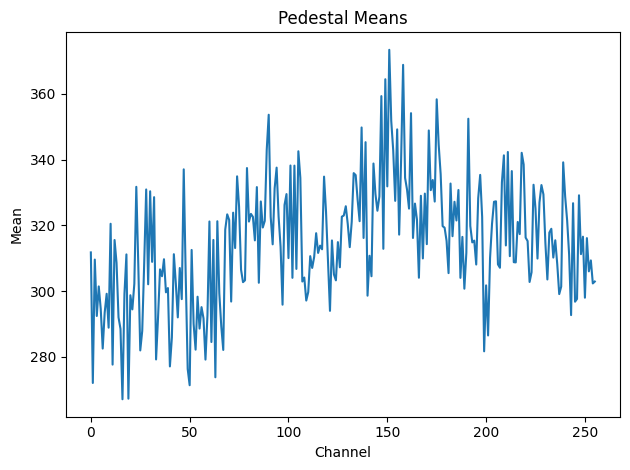

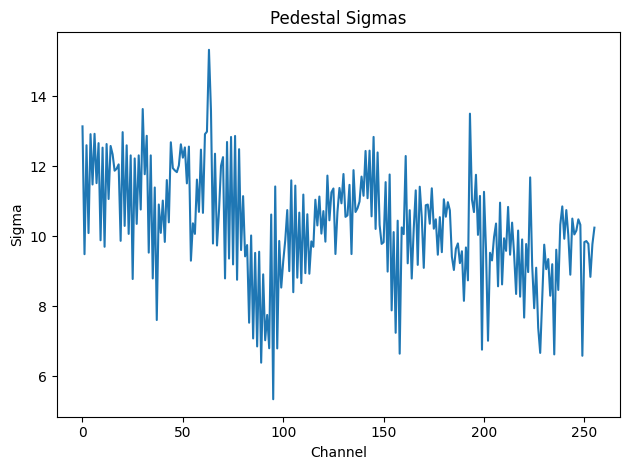

In [6]:
det.dream_data.plot_pedestals()

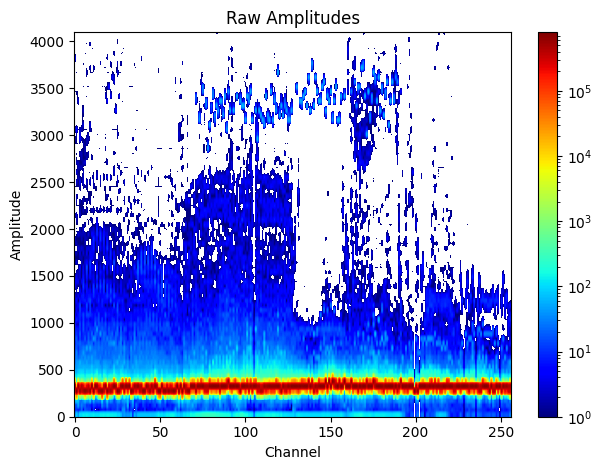

In [7]:
det.dream_data.plot_raw_amps_2d_hist()

In [8]:
# for event_num in range(min(len(det.dream_data.hits), 20)):
    # det.plot_event_1d(event_num)
    # det.plot_event_2d(event_num)
    # det.dream_data.plot_waveforms(event_num)

In [9]:
# det.dream_data.plot_noise_metric()

Connector 1 Dead Strips: []
Connector 2 Dead Strips: []
Connector 3 Dead Strips: []
Connector 4 Dead Strips: []


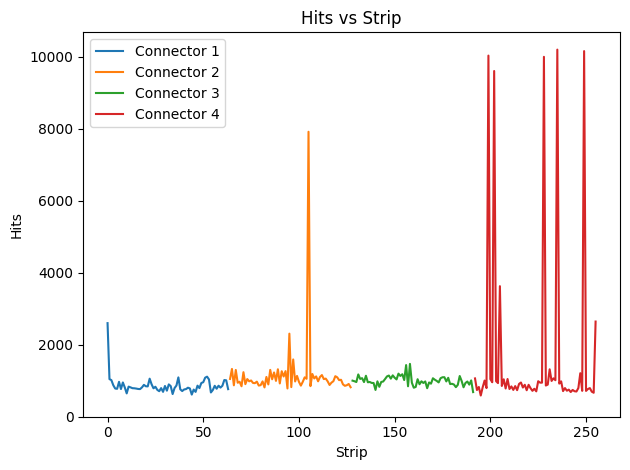

In [10]:
det.dream_data.plot_hits_vs_strip(print_dead_strips=True)

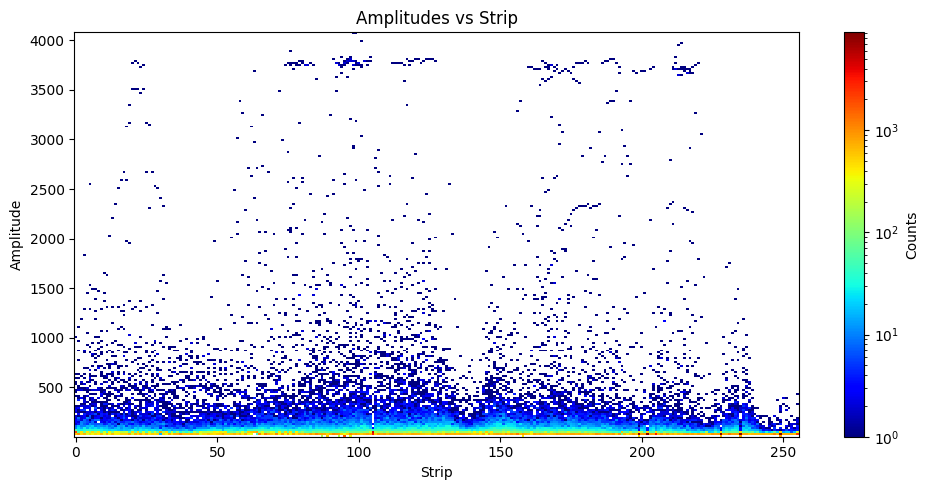

In [11]:
det.dream_data.plot_amplitudes_vs_strip()

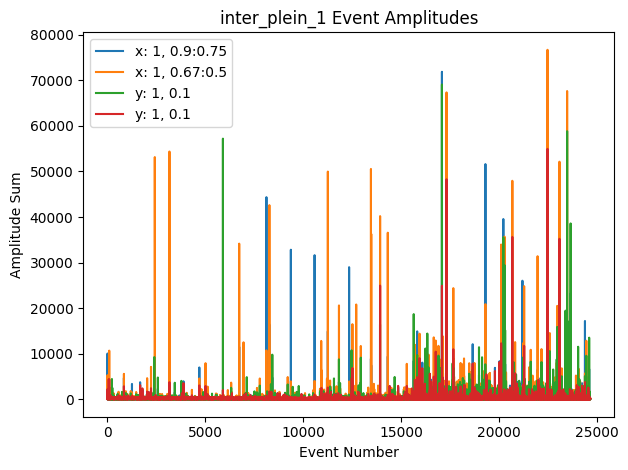

In [12]:
det.make_sub_detectors()
event_nums = det.plot_xy_amp_sum_vs_event_num(True, 500, False, 15)

# if realign_dream:
#     det.add_rotation(90, 'z')

Detector center: [  9.2  38.4 712. ]
Detector rotations: []


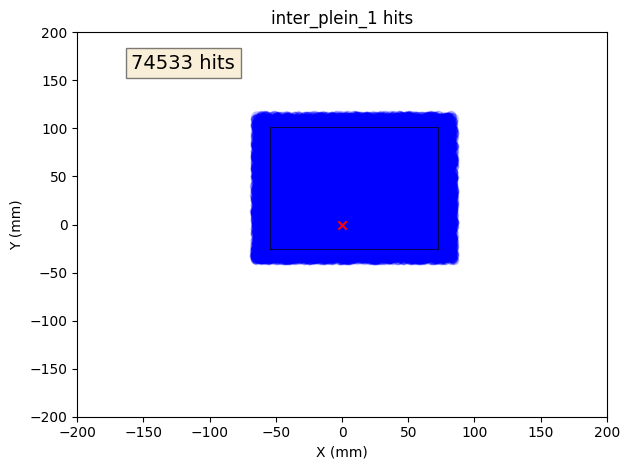

In [13]:
plot_ray_hits_2d(det, ray_data)
print(f'Detector center: {det.center}')
print(f'Detector rotations: {det.rotations}')

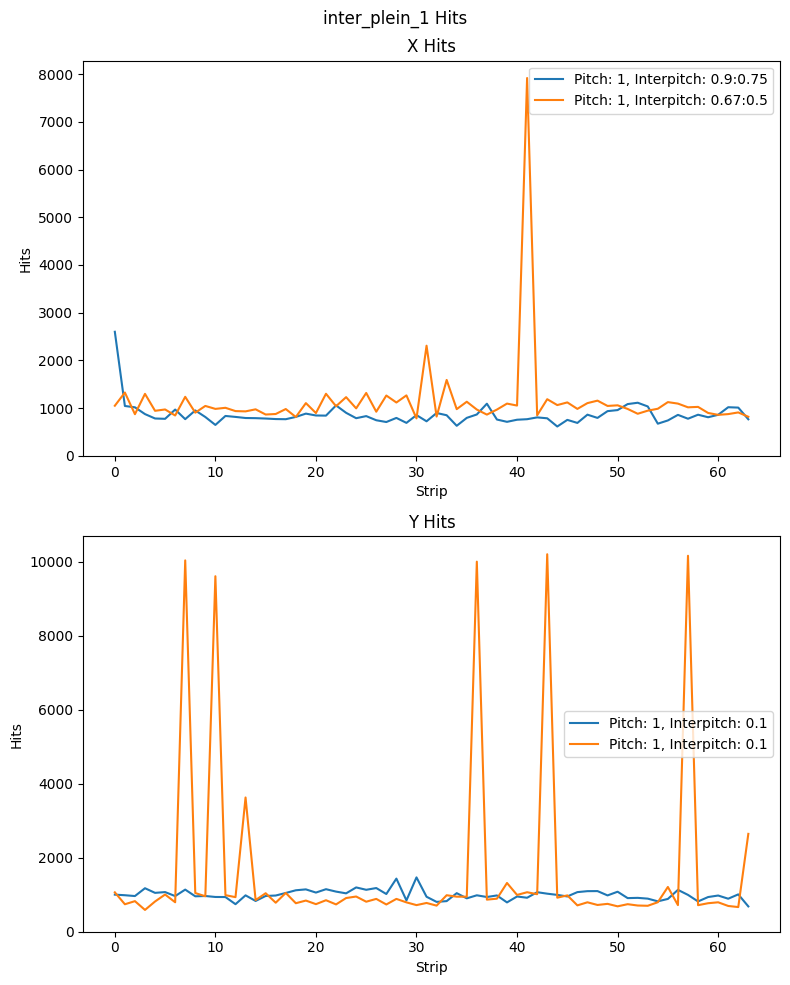

In [14]:
det.plot_hits_1d()

In [15]:
print(len(det.dream_data.hits))

24656


In [16]:
# for event_num in range(min(len(det.dream_data.hits), 2)):
#     det.plot_event_1d(event_num)
#     det.plot_event_2d(event_num)
#     det.dream_data.plot_waveforms(event_num)

In [17]:
# z_orig = det.center[2]
# x_bnds = det.center[0] - det.size[0] / 2, det.center[0] + det.size[0] / 2
# y_bnds = det.center[1] - det.size[1] / 2, det.center[1] + det.size[1] / 2
# ray_traversing_triggers = ray_data.get_traversing_triggers(z_orig, x_bnds, y_bnds, expansion_factor=0.1)

alignment_file = f'{alignment_dir}{det.name}_alignment.txt'
if realign_dream:
    # det.add_rotation(-90, 'z')
    align_dream(det, ray_data, z_align_range, z_rot_range)
    det.write_det_alignment_to_file(alignment_file)
else:
    det.read_det_alignment_from_file(alignment_file)

In [18]:
if realign_dream:
    # det.add_rotation(-90, 'z')
    align_dream(det, ray_data, z_align_range, z_rot_range)
    det.write_det_alignment_to_file(alignment_file)
else:
    det.read_det_alignment_from_file(alignment_file)

Detector center: [ 15.29425711  66.14521906 707.86206897]
Detector rotations: [[-0.5172413793103443, 0.0, 0.0], [0.1724137931034484, 0.0, 0.0]]


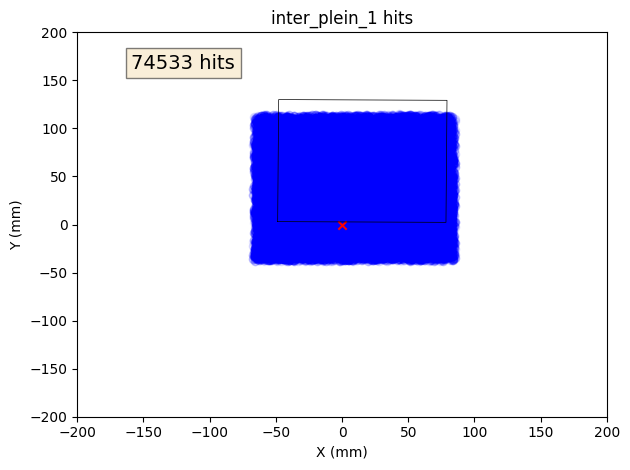

In [19]:
plot_ray_hits_2d(det, ray_data)
print(f'Detector center: {det.center}')
print(f'Detector rotations: {det.rotations}')

Pre-filtered rays: 120059
All rays: 24272


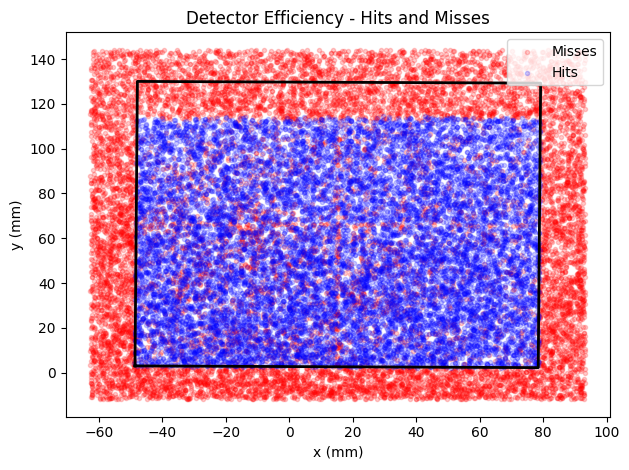

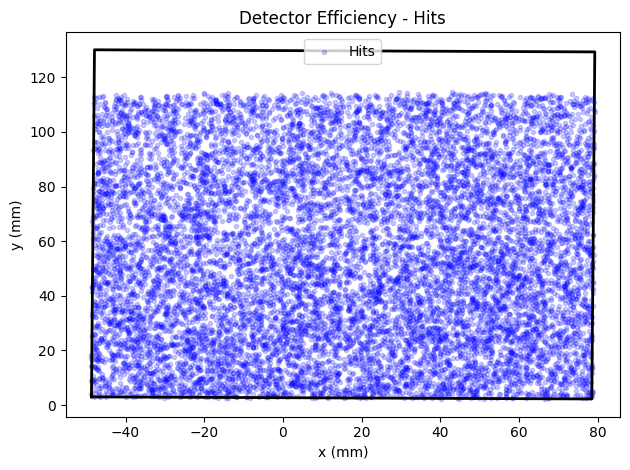

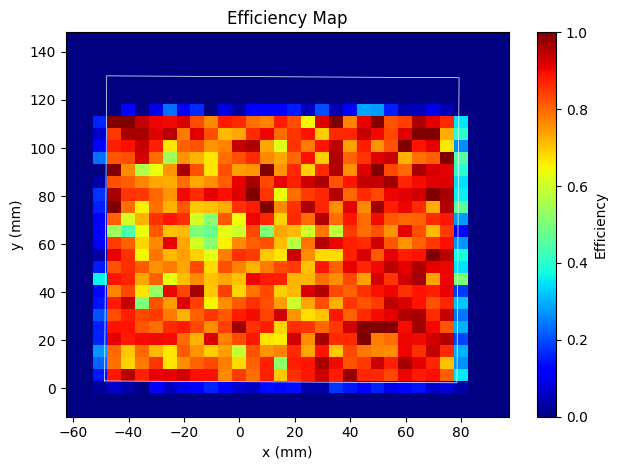

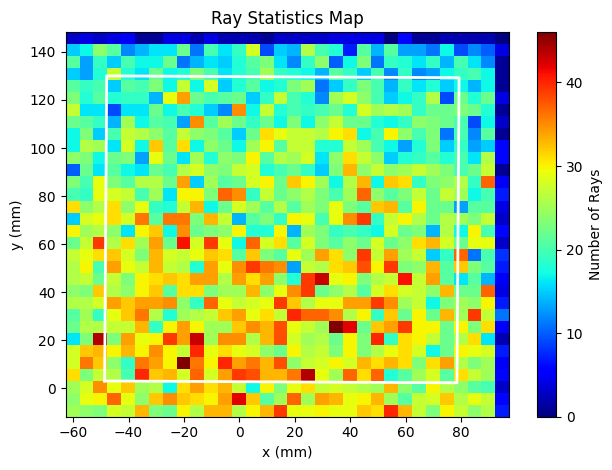

In [20]:
get_efficiency(det, ray_data, plot=True, in_det=True, tolerance=0.2)

X Residuals: Mean=-25μm, Std=1024μm
Y Residuals: Mean=-110μm, Std=760μm
X Residuals: Mean=-84μm, Std=874μm
Y Residuals: Mean=-30μm, Std=1039μm
X Residuals: Mean=29μm, Std=864μm
Y Residuals: Mean=70μm, Std=857μm
X Residuals: Mean=-167μm, Std=884μm
Y Residuals: Mean=92μm, Std=1081μm


(-0.05425099125035342,
 -0.014901305727230937,
 0.9075278500936027,
 0.8879752326959751)

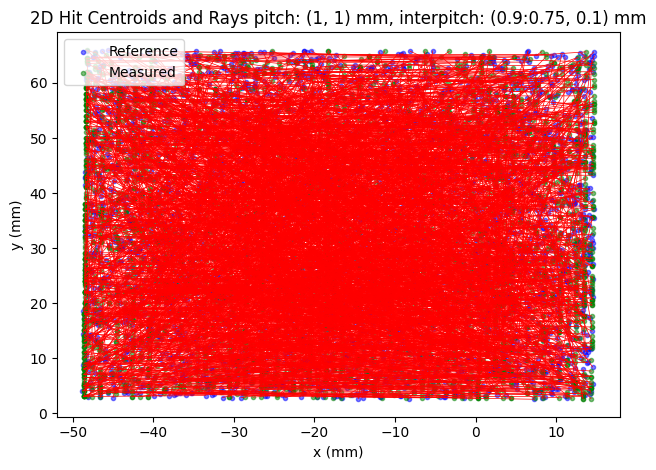

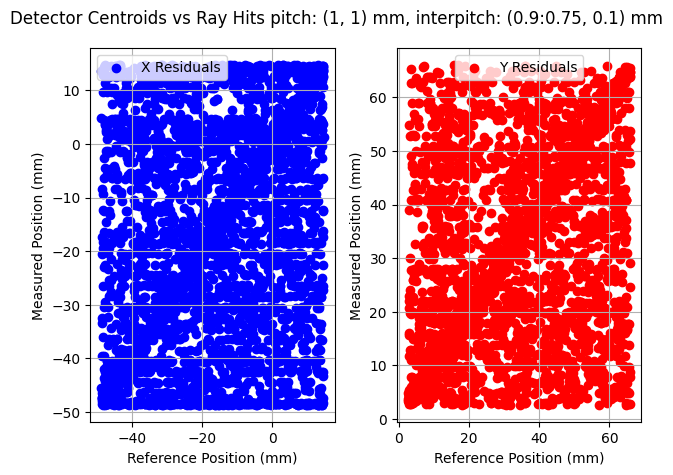

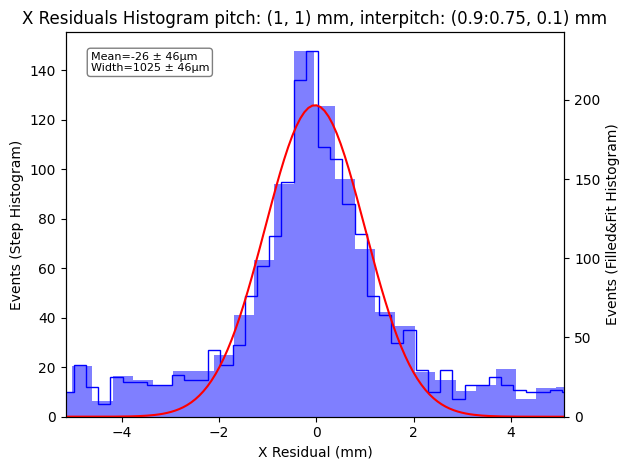

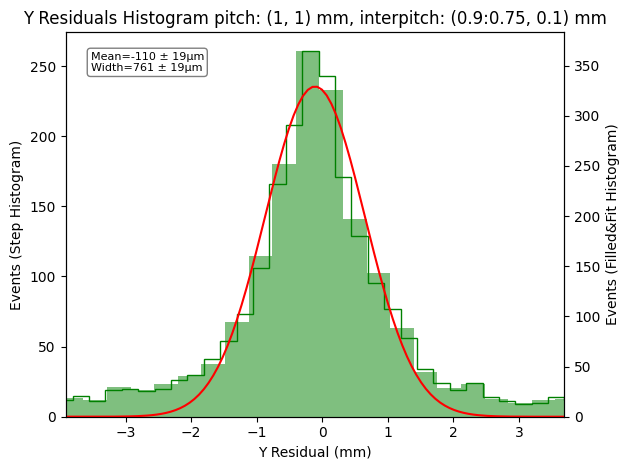

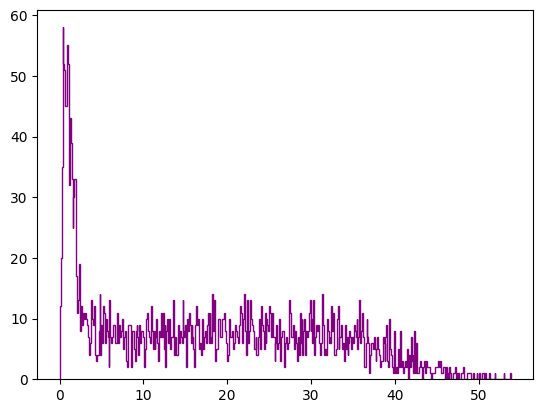

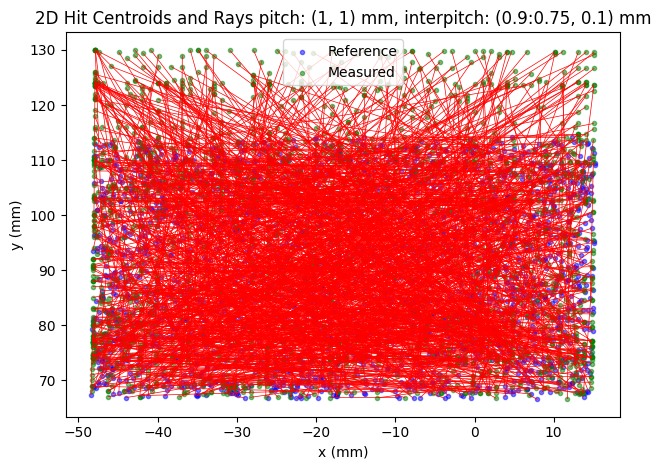

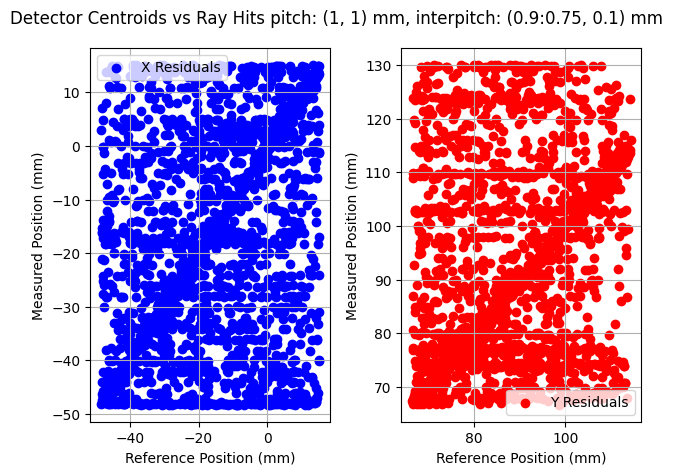

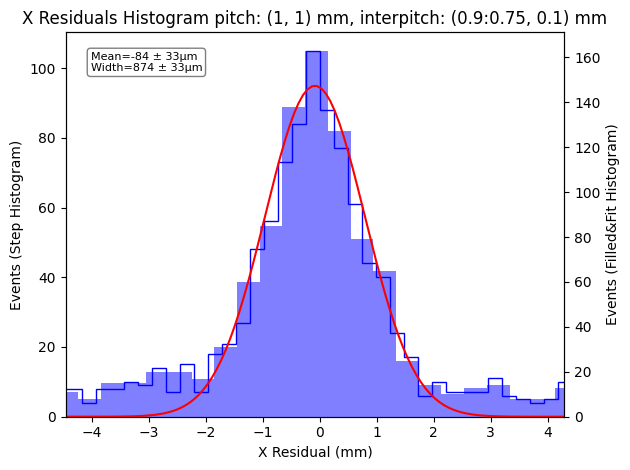

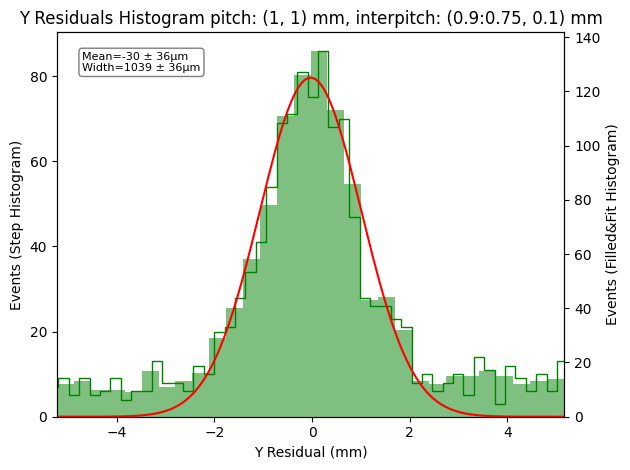

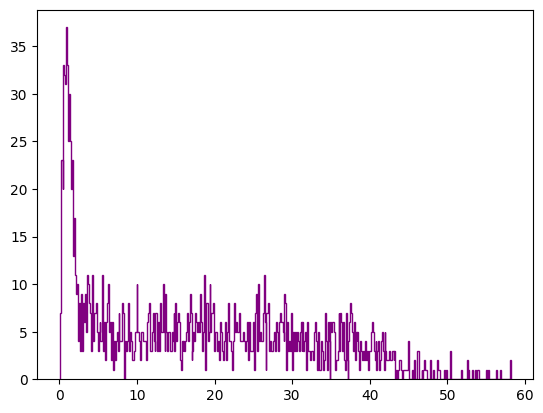

C:\Users\Dylan\anaconda3\envs\saclay_micromegas\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


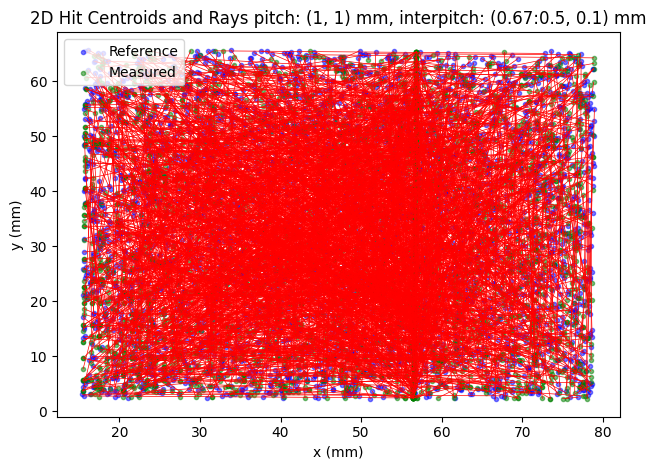

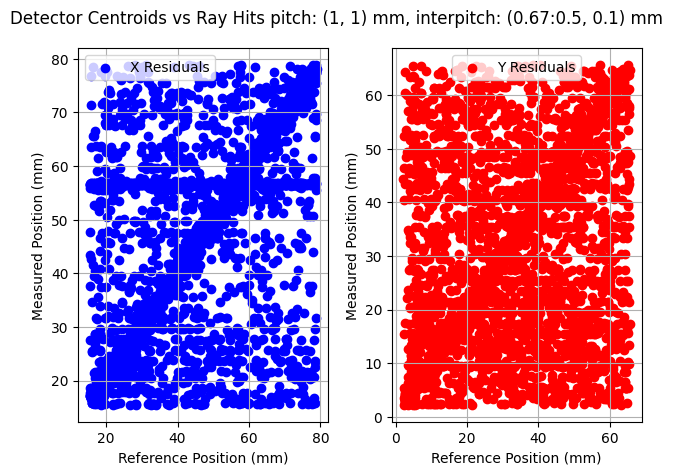

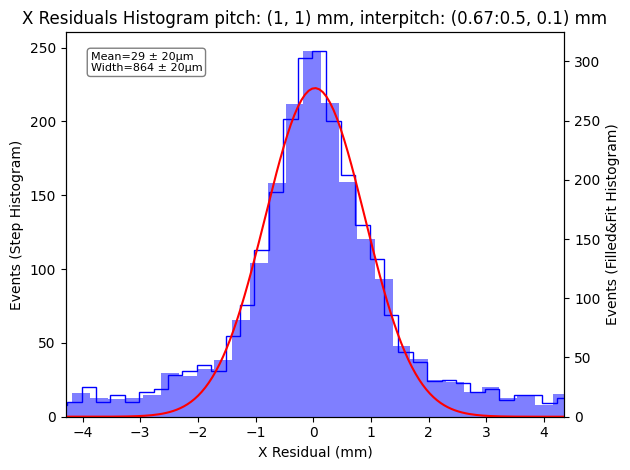

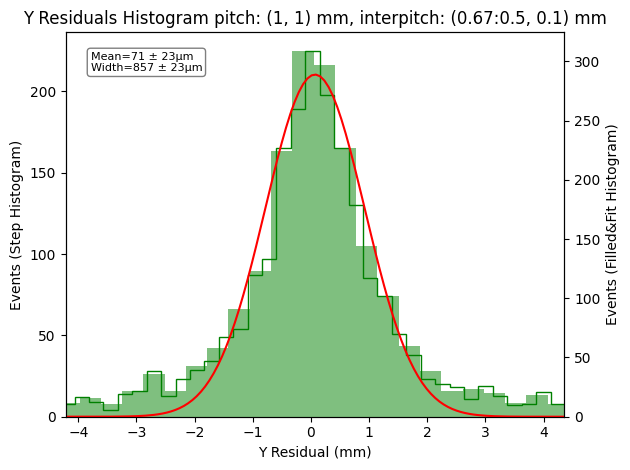

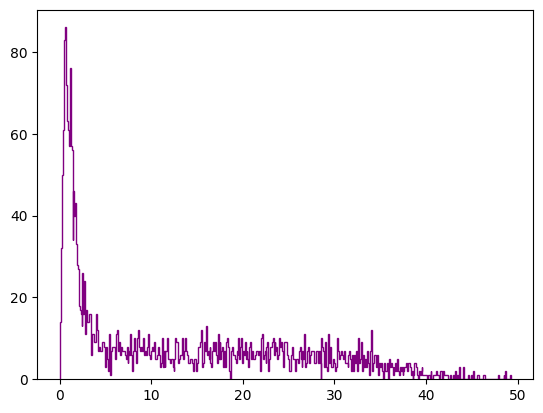

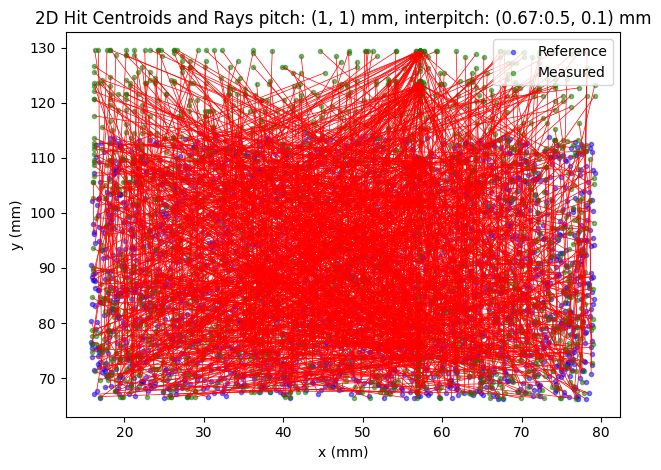

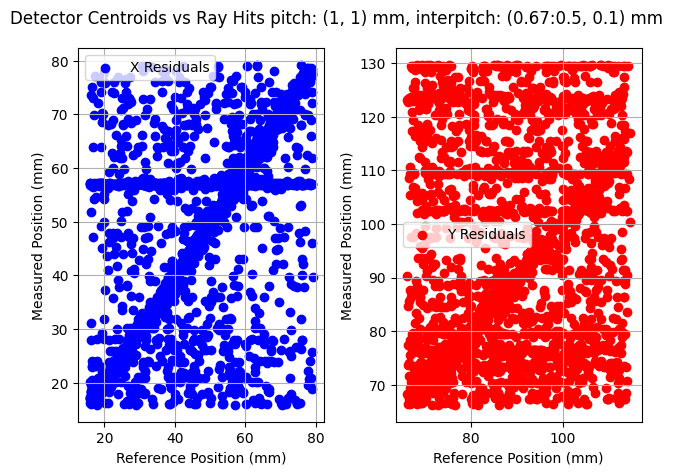

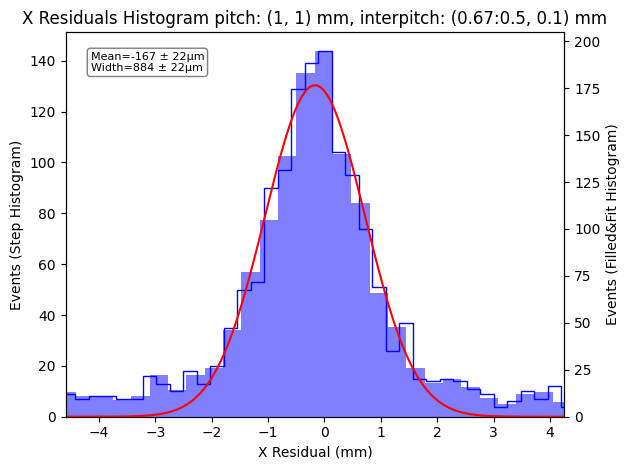

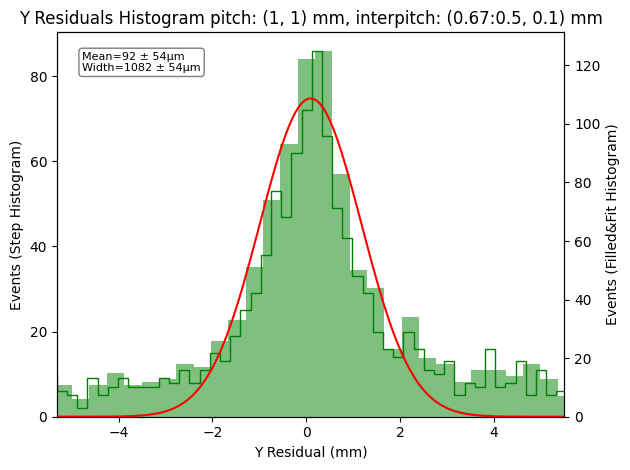

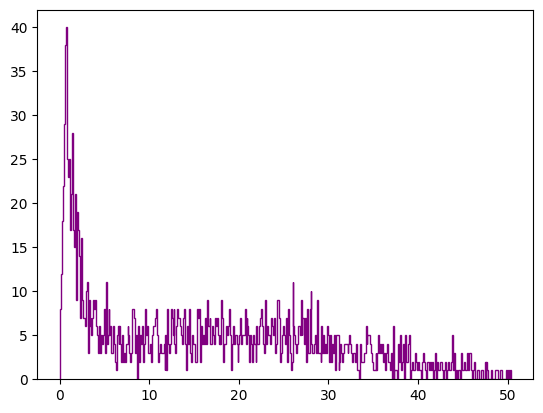

In [21]:
get_residuals(det, ray_data, plot=True, in_det=True, tolerance=0.2)

New stuff above

In [22]:
print(det.sub_detectors)

[<DreamSubDetector.DreamSubDetector object at 0x000001B01FA412B0>, <DreamSubDetector.DreamSubDetector object at 0x000001B01FA41700>, <DreamSubDetector.DreamSubDetector object at 0x000001B01FA41730>, <DreamSubDetector.DreamSubDetector object at 0x000001B01FA41FD0>]


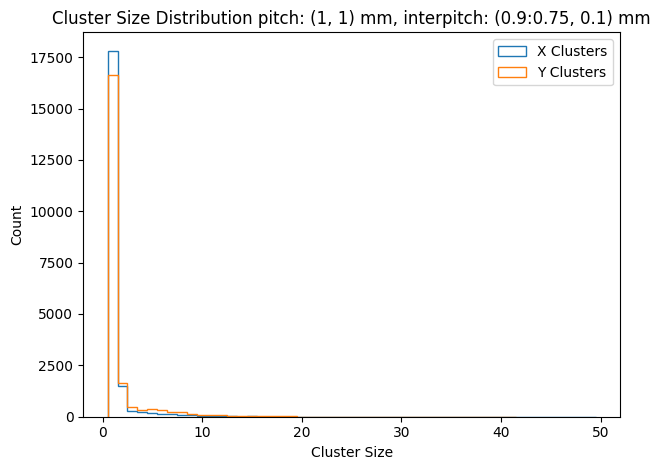

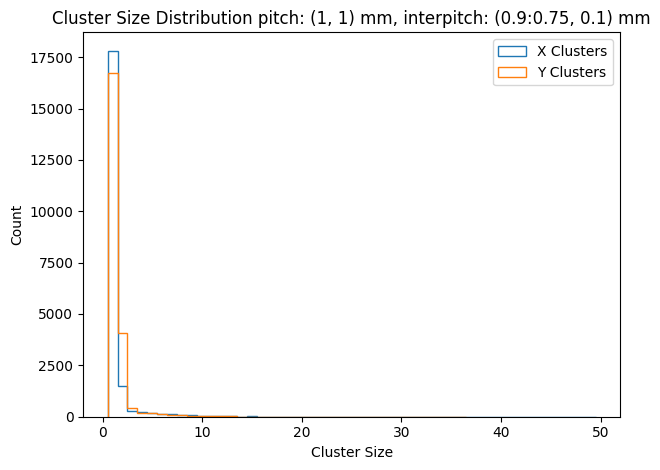

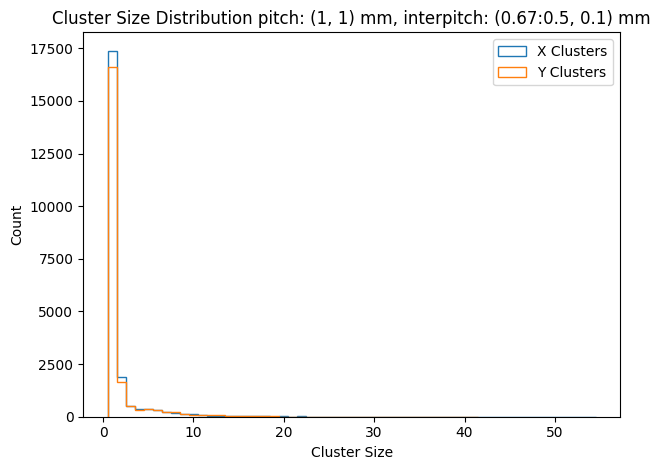

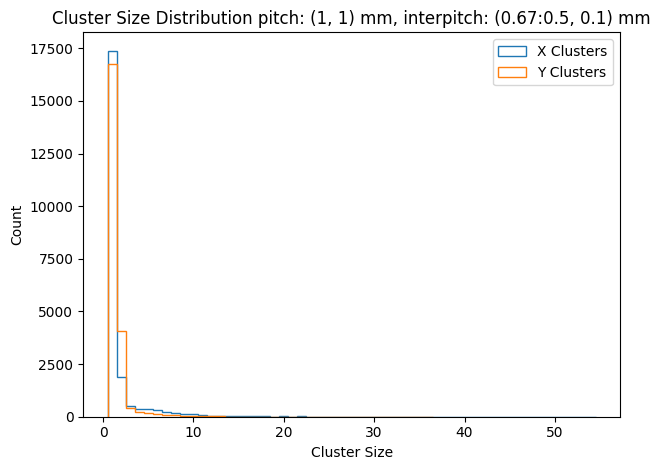

In [23]:
for sub_det in det.sub_detectors:
    sub_det.plot_cluster_sizes()

In [24]:
#Do 1D efficiency
#Cluster sizes

Do 1D efficiency
Cluster sizes